In [8]:
import pandas as pd
import datetime as dt
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam


In [10]:
import tensorflow
print(tensorflow.__version__)

2.3.1


## 1. Preprocess data
Download Chicago crime data from 2001 to present
https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data


In [176]:
# read csv file
df = pd.read_csv("Crimes_-_2001_to_Present.csv") 
print(df.shape)

(7309449, 22)


In [177]:
#remove na items
df=df.dropna()
print(df.shape)

(6625170, 22)


In [180]:
#remove duplicated items
df = df[['ID', 'Date', 'Year', 'Primary Type', 
        'Description', 'Location Description', 'Arrest', 
        'Domestic', 'District', 'Latitude', 'Longitude']]
df=df.drop_duplicates()
print(df.shape)

(6625170, 11)


In [182]:
#group the data by date, and save it to csv file.
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.sort_values(by=['Date'], inplace=True, ascending=True)
#print(df.head())
#print(df.tail())
cnt = df.groupby('Date').size().rename('Count')
result = df.drop_duplicates(subset='Date').merge(cnt, left_on='Date', right_index=True)      
print(result.shape)
#print(result.head())
result.to_csv('crimes_formatted.csv')

(7403, 12)


## 2. Read saved csv file from step1

In [3]:
#read data
grouped_data =  pd.read_csv("crimes_formatted.csv") 
print(grouped_data.shape[0])

7403


In [4]:
# Convert dates to date type (will be used in visualization)
datelist_train = list(grouped_data['Date'])
print(type(datelist_train[0]))
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]
print(type(datelist_train[0]))
print('All timestamps == {}'.format(len(datelist_train)))

<class 'str'>
<class 'datetime.date'>
All timestamps == 7403


In [5]:
from datetime import datetime
# convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

grouped_data = grouped_data.set_index(pd.Series(datelist_train))
grouped_data.index = grouped_data.index.to_series().apply(datetime_to_timestamp)
grouped_data.index

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-05',
               '2001-01-06', '2001-01-07', '2001-01-08', '2001-01-09',
               '2001-01-10', '2001-01-11',
               ...
               '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05',
               '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09',
               '2021-04-10', '2021-04-11'],
              dtype='datetime64[ns]', length=7403, freq=None)

## 3. Define train data: crime number for each day

In [6]:
train_data = grouped_data["Count"].astype(float).values
print(type(train_data))
train_data = train_data.reshape(len(train_data),1)
print('Shape of training set == {}.'.format(train_data.shape))
train_data

<class 'numpy.ndarray'>
Shape of training set == (7403, 1).


array([[274.],
       [ 10.],
       [  4.],
       ...,
       [456.],
       [467.],
       [422.]])

## 4. Standardize the data

In [7]:
sc = StandardScaler()
training_scaled = sc.fit_transform(train_data)
print(training_scaled.shape)
print(training_scaled)

(7403, 1)
[[-1.79240588]
 [-2.55448022]
 [-2.5718001 ]
 ...
 [-1.26703645]
 [-1.23528335]
 [-1.36518238]]


## 5. Create a training data with 21 sequential data and 1 output
#For example: 1,2,3,....................100.
             #X_trian[0]:1,2,3,...21,Y_train[0]: 28
             #X_trian[1]:2,3,4,...22,Y_train[1]: 29
             #......

In [67]:
X_train = []
y_train = []

n_future = 7   # Number of days we want to predict into the future
n_past = 21     # Number of past days we want to use to predict the future

for i in range(n_past, len(train_data) - n_future +1):
    X_train.append(training_scaled[i - n_past:i,:])
    y_train.append(training_scaled[i + n_future - 1:i + n_future,0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (7376, 21, 1).
y_train shape == (7376, 1).


## 6. Build the LSTM based Neural Network model

In [68]:
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, 1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=64, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=5e-3), loss='mean_squared_error')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 21, 64)            16896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


## 7. Train the model

In [71]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = keras.callbacks.ModelCheckpoint(filepath='weights.h5', monitor='val_loss', 
                                      verbose=1, save_best_only=True, save_weights_only=True)
tb = keras.callbacks.TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, 
                    callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
23/24 [===========================>..] - ETA: 0s - loss: 0.1821
Epoch 00001: val_loss improved from inf to 0.07828, saving model to weights.h5
24/24 [==============================] - 2s 93ms/step - loss: 0.1819 - val_loss: 0.0783
Epoch 2/30
23/24 [===========================>..] - ETA: 0s - loss: 0.1085
Epoch 00002: val_loss improved from 0.07828 to 0.05167, saving model to weights.h5
24/24 [==============================] - 1s 56ms/step - loss: 0.1085 - val_loss: 0.0517
Epoch 3/30
23/24 [===========================>..] - ETA: 0s - loss: 0.1061
Epoch 00003: val_loss improved from 0.05167 to 0.05167, saving model to weights.h5
24/24 [==============================] - 2s 64ms/step - loss: 0.1060 - val_loss: 0.0517
Epoch 4/30
23/24 [===========================>..] - ETA: 0s - loss: 0.0989
Epoch 00004: val_loss did not improve from 0.05167
24/24 [==============================] - 1s 51ms/step - loss: 0.0991 - val_loss: 0.0524
Epoch 5/30
24/24 [==============================] - 

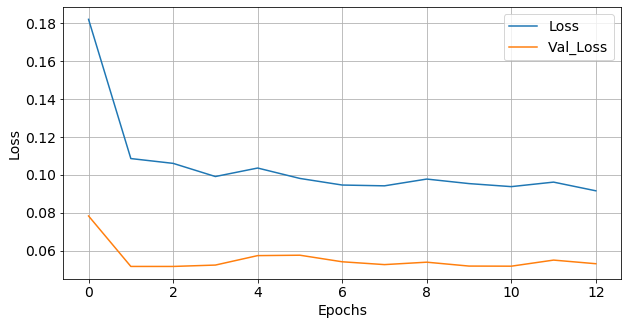

In [72]:
#Visualizing training and validaton loss

fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(model.history.history['loss'], label = 'Loss')
ax.plot(model.history.history['val_loss'], Label = 'Val_Loss')
ax.set_xlabel('Epochs', fontsize = 14)
ax.set_ylabel('Loss', fontsize = 14)
ax.grid(True)
ax.legend(fontsize = 14)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)

# fig.savefig('loss.png', bbox_inches = 'tight');

## 8. Perform predictions

In [73]:
# Perform predictions on future 7 days 
predictions_future = model.predict(X_train[-n_future:])
# Perform predictions on past days
predictions_train = model.predict(X_train[n_past:])

#Convert the scaled prediction back to normal 
y_pred_future = sc.inverse_transform(predictions_future)
y_pred_train = sc.inverse_transform(predictions_train)


In [74]:
y_pred_future

array([[519.95374],
       [520.7649 ],
       [510.5584 ],
       [503.91653],
       [503.601  ],
       [513.319  ],
       [522.55707]], dtype=float32)

In [75]:
y_pred_train

array([[ 26.976576],
       [ 28.599073],
       [ 28.608595],
       ...,
       [503.60098 ],
       [513.319   ],
       [522.55707 ]], dtype=float32)

In [76]:
# Generate two dataframes of prediction data for visualization use.
#Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=(n_future+1), freq='1d').tolist()

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Count']).set_index(pd.Series(datelist_future[1:]))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, 
                                columns=['Count']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

print(PREDICTIONS_FUTURE.shape)
print(PREDICTION_TRAIN.shape)
print(PREDICTIONS_FUTURE)

(7, 1)
(7355, 1)
                 Count
2021-04-12  519.953735
2021-04-13  520.764893
2021-04-14  510.558411
2021-04-15  503.916534
2021-04-16  503.601013
2021-04-17  513.318970
2021-04-18  522.557068


## 9. Mean Squared Error

In [77]:
# From 2001-02-21 to 2021 - 04-11
grouped_data_2 = grouped_data.loc['2001-02-21':]['Count']
n = PREDICTION_TRAIN.shape[0]
MSE = np.sum((PREDICTION_TRAIN['Count']-grouped_data_2)**2)/n
MSE

9111.956335259281

## 10. Visualize the Predictions

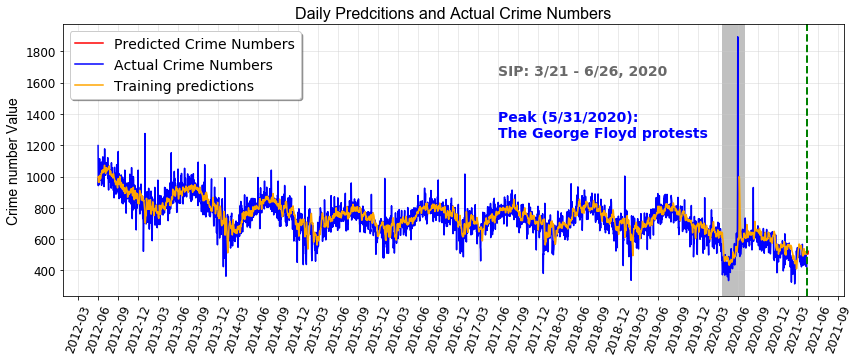

In [78]:
# Set plot size 
from pylab import rcParams

rcParams['figure.figsize'] = 14, 5

fig,ax = plt.subplots(figsize = (14, 5))

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from pandas.plotting import register_matplotlib_converters

fmt_half_year = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_half_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Count'], color='r', label='Predicted Crime Numbers')
ax.plot(grouped_data.loc[START_DATE_FOR_PLOTTING:].index, 
         grouped_data.loc[START_DATE_FOR_PLOTTING:]['Count'], color='b', label='Actual Crime Numbers')
ax.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, 
         PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Count'], color='orange', label='Training predictions')

ax.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

ax.grid(which='major', color='#cccccc', alpha=0.5)


# add a rectangle
# https://coronavirus.illinois.gov/s/stay-at-home-faqs
# "stay home" order starting on 2020-03-21 and on 2020-6-26 safely expands operations 
# for businesses and communities based on compliance with the safety guidelines

rect = mpatches.Rectangle([737506, 200], 97, 1800, linewidth=1,
                          edgecolor='silver', facecolor='silver')

ax.add_patch(rect)

ax.legend(shadow=True, fontsize = 14)
ax.xaxis.set_tick_params(rotation=70)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.set_title('Daily Predcitions and Actual Crime Numbers', family='Arial', fontsize=16)

ax.set_ylabel('Crime number Value', family='Arial', fontsize=14)
ax.annotate('SIP: 3/21 - 6/26, 2020',(736480, 1650), color = 'dimgrey', 
            fontsize = 14,fontweight='bold' )
ax.annotate('Peak (5/31/2020):\nThe George Floyd protests', (736480, 1250), 
            color = 'blue', fontsize = 14, fontweight='bold');

# fig.savefig('Prediction-actual-crime.png', bbox_inches = 'tight')

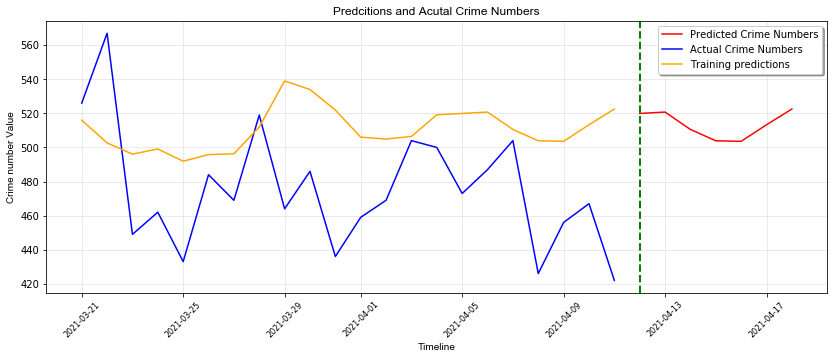

In [79]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-03-21'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Count'], color='r', label='Predicted Crime Numbers')
plt.plot(grouped_data.loc[START_DATE_FOR_PLOTTING:].index, 
         grouped_data.loc[START_DATE_FOR_PLOTTING:]['Count'], color='b', label='Actual Crime Numbers')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, 
         PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Count'], color='orange', label='Training predictions')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Crime Numbers', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Crime number Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

## 11. Anomalies detection

Max difference: 1325.0728759765625


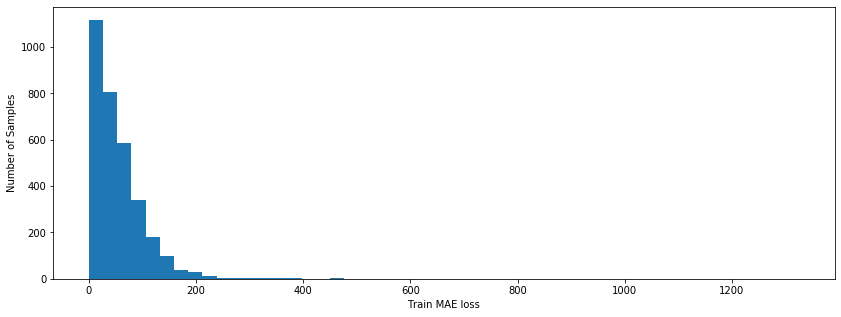

In [80]:
START_DATE_FOR_PLOTTING = '2012-06-01'
#Actual - predict
train_mae_loss = np.abs(grouped_data.loc[START_DATE_FOR_PLOTTING:]['Count'] -
                        PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Count'])
                                

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

max_diff = np.max(train_mae_loss)
print(f'Max difference: {max_diff}')

In [81]:
#Set the threshold to the 1% largest difference
import heapq
outliers_fraction = 0.01
number_of_outliers = int(outliers_fraction*len(train_mae_loss))
n_largest = heapq.nlargest(number_of_outliers, train_mae_loss)
threshold = min(n_largest)
print(f'Threshold: {threshold}')
print(f'Number of anomalies: {number_of_outliers}')

Threshold: 223.6387939453125
Number of anomalies: 32


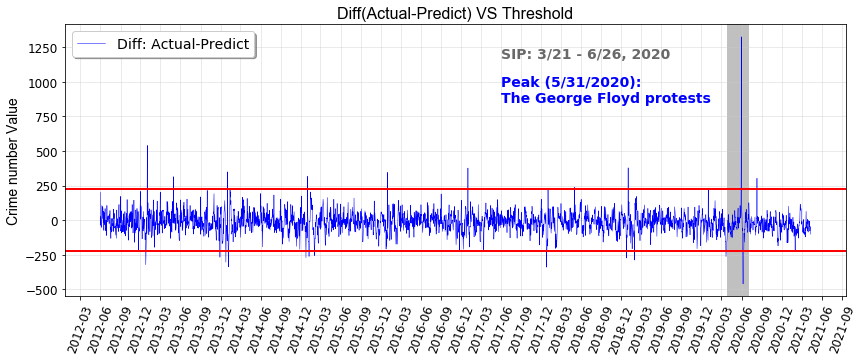

In [82]:
fig, ax = plt.subplots(figsize = (14, 5))

fmt_half_year = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(fmt_half_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.plot(grouped_data.loc[START_DATE_FOR_PLOTTING:].index, 
         grouped_data.loc[START_DATE_FOR_PLOTTING:]['Count'] - 
         PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Count'], 
         color='b', label='Diff: Actual-Predict', linewidth=0.5)

ax.axhline(y = threshold, color='red', linewidth=2, linestyle='-')
ax.axhline(y = -threshold, color='red', linewidth=2, linestyle='-')

ax.grid(which='major', color='#cccccc', alpha=0.5)

ax.legend(shadow=True, fontsize = 14)
ax.xaxis.set_tick_params(rotation=70)

# add a rectangle
# https://coronavirus.illinois.gov/s/stay-at-home-faqs
# "stay home" order starting on 2020-03-21 and on 2020-6-26 safely expands operations 
# for businesses and communities based on compliance with the safety guidelines

rect = mpatches.Rectangle([737510, -750], 97, 2250, linewidth=1,
                          edgecolor='silver', facecolor='silver')
ax.add_patch(rect)

ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.set_title('Diff(Actual-Predict) VS Threshold', family='Arial', fontsize=16)

ax.set_ylabel('Crime number Value', family='Arial', fontsize=14)

ax.annotate('SIP: 3/21 - 6/26, 2020',(736480, 1170), color = 'dimgrey', 
            fontsize = 14,fontweight='bold' )
ax.annotate('Peak (5/31/2020):\nThe George Floyd protests', (736480, 850), 
            color = 'blue', fontsize = 14, fontweight='bold');

# fig.savefig('Abnormalies.png', bbox_inches = 'tight')